In [1]:
import random
import gym

In [2]:
env=gym.make('CartPole-v1')

In [4]:
for episode in range(5):
    env.reset()
    for t in range(200):
        env.render()
        action=env.action_space.sample()
        observation,reward,done,info=env.step(action)
env.close()

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from statistics import median, mean
from collections import Counter


In [9]:
initial_games=10000
goal_steps=500
score_requirement=50


In [22]:
def generate_games():
    training_data=[]
    scores=[]
    accepted_scores=[]
    
    for _ in range(initial_games):
        score=0
        game_memory=[]
        prev_observation=[]
        
        for _ in range(goal_steps):
            action=random.randrange(0,2)
            observation,reward,done,info=env.step(action)
            if len(prev_observation)>0:
                game_memory.append([prev_observation,action])
            prev_observation=observation
            score+=reward
            if done:break
        if score>= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                if data[1]==1:
                    output=[0,1]
                elif data[1]==0:
                    output=[1,0]
                training_data.append([data[0],output])
        env.reset()
        scores.append(score)
    training_data_save=np.array(training_data)
    np.save('saved.npy',training_data_save)
    
    print('Average accepted score:', mean(accepted_scores))
    print('Median score for accepted scores:',median(accepted_scores))
    print(Counter(accepted_scores))
    
    return training_data, Counter(accepted_scores)
        
        
                    
                    
                    

                

In [23]:
training_data,accepted_scores=generate_games()

Average accepted score: 62.12771739130435
Median score for accepted scores: 59.0
Counter({50.0: 31, 52.0: 29, 51.0: 26, 53.0: 24, 54.0: 19, 59.0: 17, 61.0: 17, 60.0: 16, 56.0: 16, 63.0: 15, 57.0: 15, 55.0: 14, 64.0: 10, 69.0: 10, 58.0: 8, 65.0: 8, 71.0: 7, 78.0: 6, 62.0: 6, 80.0: 5, 67.0: 5, 66.0: 5, 82.0: 4, 70.0: 4, 74.0: 4, 75.0: 3, 72.0: 3, 85.0: 3, 83.0: 3, 97.0: 3, 68.0: 3, 89.0: 3, 76.0: 2, 73.0: 2, 105.0: 2, 86.0: 2, 87.0: 2, 77.0: 1, 112.0: 1, 107.0: 1, 93.0: 1, 92.0: 1, 88.0: 1, 116.0: 1, 90.0: 1, 115.0: 1, 101.0: 1, 91.0: 1, 84.0: 1, 100.0: 1, 81.0: 1, 79.0: 1, 108.0: 1})


<BarContainer object of 53 artists>

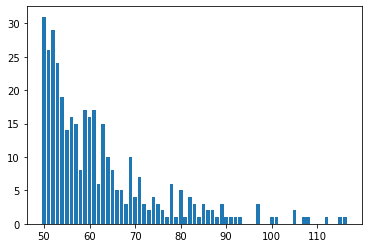

In [24]:

%matplotlib inline
plt.bar(accepted_scores.keys(), accepted_scores.values())

In [25]:
model=tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_shape=[1,4],activation=tf.nn.relu),
    tf.keras.layers.Dense(256,activation=tf.nn.relu),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
    tf.keras.layers.Dense(2,activation=tf.nn.softmax)
    
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 128)            640       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 256)            33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 128)            32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 2)              258       
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________


In [27]:
X=tf.convert_to_tensor([tf.expand_dims(d[0],0) for d in training_data],dtype=tf.float32)
y=tf.convert_to_tensor([i[1] for i in training_data],dtype=tf.float32)


In [28]:
X=X[:20000]
y=y[:20000]

In [29]:
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).batch(1)

In [30]:
feature, target = next(iter(train_ds))
feature[0]

<tf.Tensor: id=90225, shape=(1, 4), dtype=float32, numpy=
array([[-0.03367406,  0.19583127,  0.01309468, -0.25228438]],
      dtype=float32)>

In [31]:
optimizer = tf.keras.optimizers.Adam(1e-3)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [32]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [33]:
print(model(tf.expand_dims(feature[0], 0), training=True).numpy())

[[[0.4957709 0.5042291]]]


In [34]:

model.fit(train_ds, epochs=5, steps_per_epoch=500)

Train for 500 steps
Epoch 1/5
500/500 [==============================] - 4s 8ms/step - loss: 0.6836 - accuracy: 0.5860
Epoch 2/5
500/500 [==============================] - 2s 5ms/step - loss: 0.6732 - accuracy: 0.6100
Epoch 3/5
500/500 [==============================] - 2s 5ms/step - loss: 0.6742 - accuracy: 0.5760
Epoch 4/5
500/500 [==============================] - 2s 5ms/step - loss: 0.6635 - accuracy: 0.6040
Epoch 5/5
500/500 [==============================] - 2s 5ms/step - loss: 0.6822 - accuracy: 0.5900


In [35]:
model.predict(tf.expand_dims(feature[0], 0))

array([[[0.7197696 , 0.28023046]]], dtype=float32)

In [36]:

env.reset()
obs, reward, done, _ = env.step(env.action_space.sample())
tf.cast(tf.reshape(obs, [1, 1, -1]), tf.float32)

<tf.Tensor: id=99007, shape=(1, 1, 4), dtype=float32, numpy=
array([[[ 0.04910986, -0.18131298, -0.0032749 ,  0.27630872]]],
      dtype=float32)>

In [37]:

for game in range(10):
    score = 0
    prev_obs = []
    env.reset()
    for _ in range(500):
        env.render()
        
        if len(prev_obs) == 0:
            action = random.randrange(0, 2)
        else:
            prepared_obs = tf.cast(tf.reshape(prev_obs, [1, 1, -1]), tf.float32)
        
            action = np.argmax(model(prepared_obs))
        
        
        new_observation, reward, done, info = env.step(action)
        prev_obs = new_observation
        score += reward
        
        if done: break
    
env.close()